In [21]:
# COCO classes
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

coco_idx_to_label = {idx: label for idx, label in enumerate(CLASSES)}

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


In [2]:
import os
os.environ["PYDEVD_DISABLE_VARIABLE_LOOKUP"] = "1"

In [20]:
import matplotlib.pyplot as plt
import torch
import torchvision

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        print("rectangle coords: ", (xmin, ymin, xmax, ymax))
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[label]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [5]:
from argparse import Namespace
import os
args = Namespace(config='projects/configs/co_deformable_detr/co_deformable_detr_r50_1x_coco.py', work_dir='my_exp1', resume_from=None, auto_resume=False, no_validate=False, gpus=None, gpu_ids=None, gpu_id=0, seed=None, diff_seed=False, deterministic=False, options=None, cfg_options=None, launcher='pytorch', local_rank=0, auto_scale_lr=False)

os.environ['LOCAL_RANK'] = '0'
os.environ['RANK'] = '0'
os.environ['GROUP_RANK'] = '0'
os.environ['ROLE_RANK'] = '0'
os.environ['ROLE_NAME'] = 'default'
os.environ['LOCAL_WORLD_SIZE'] = '1'
os.environ['WORLD_SIZE'] = '1'
os.environ['GROUP_WORLD_SIZE'] = '1'
os.environ['ROLE_WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29500'


In [6]:
import argparse
import copy
import os
import os.path as osp
import time
import warnings

import mmcv
import torch
import torch.distributed as dist
from mmcv import Config, DictAction
from mmcv.runner import get_dist_info, init_dist
from mmcv.utils import get_git_hash

from mmdet import __version__
from mmdet.apis import init_random_seed, set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import (collect_env, get_device, get_root_logger,
                         replace_cfg_vals, setup_multi_processes,
                         update_data_root)
from projects import *

In [7]:
cfg = Config.fromfile(args.config)
cfg = replace_cfg_vals(cfg)
update_data_root(cfg)
if args.cfg_options is not None:
    cfg.merge_from_dict(args.cfg_options)

if args.auto_scale_lr:
    if 'auto_scale_lr' in cfg and \
            'enable' in cfg.auto_scale_lr and \
            'base_batch_size' in cfg.auto_scale_lr:
        cfg.auto_scale_lr.enable = True
    else:
        warnings.warn('Can not find "auto_scale_lr" or '
                        '"auto_scale_lr.enable" or '
                        '"auto_scale_lr.base_batch_size" in your'
                        ' configuration file. Please update all the '
                        'configuration files to mmdet >= 2.24.1.')

# set multi-process settings
setup_multi_processes(cfg)

/home/maksimgaiduk/repos/Co-DETR/mmdet/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/home/maksimgaiduk/repos/Co-DETR/mmdet/utils/setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(


In [8]:
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

# work_dir is determined in this priority: CLI > segment in file > filename
if args.work_dir is not None:
    # update configs according to CLI args if args.work_dir is not None
    cfg.work_dir = args.work_dir
elif cfg.get('work_dir', None) is None:
    # use config filename as default work_dir if cfg.work_dir is None
    cfg.work_dir = osp.join('./work_dirs',
                            osp.splitext(osp.basename(args.config))[0])

if args.resume_from is not None:
    cfg.resume_from = args.resume_from
cfg.auto_resume = args.auto_resume
if args.gpus is not None:
    cfg.gpu_ids = range(1)
    warnings.warn('`--gpus` is deprecated because we only support '
                    'single GPU mode in non-distributed training. '
                    'Use `gpus=1` now.')
if args.gpu_ids is not None:
    cfg.gpu_ids = args.gpu_ids[0:1]
    warnings.warn('`--gpu-ids` is deprecated, please use `--gpu-id`. '
                    'Because we only support single GPU mode in '
                    'non-distributed training. Use the first GPU '
                    'in `gpu_ids` now.')
if args.gpus is None and args.gpu_ids is None:
    cfg.gpu_ids = [args.gpu_id]

# init distributed env first, since logger depends on the dist info.
if args.launcher == 'none':
    distributed = False
else:
    distributed = True
    init_dist(args.launcher, **cfg.dist_params)
    # re-set gpu_ids with distributed training mode
    _, world_size = get_dist_info()
    cfg.gpu_ids = range(world_size)

# create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# dump config
cfg.dump(osp.join(cfg.work_dir, osp.basename(args.config)))
# init the logger before other steps
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, f'{timestamp}.log')
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

# init the meta dict to record some important information such as
# environment info and seed, which will be logged
meta = dict()
# log env info
env_info_dict = collect_env()
env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
dash_line = '-' * 60 + '\n'
logger.info('Environment info:\n' + dash_line + env_info + '\n' +
            dash_line)
meta['env_info'] = env_info
meta['config'] = cfg.pretty_text
# log some basic info
logger.info(f'Distributed training: {distributed}')
logger.info(f'Config:\n{cfg.pretty_text}')

cfg.device = get_device()
# set random seeds
seed = init_random_seed(args.seed, device=cfg.device)
seed = seed + dist.get_rank() if args.diff_seed else seed
logger.info(f'Set random seed to {seed}, '
            f'deterministic: {args.deterministic}')
set_random_seed(seed, deterministic=args.deterministic)
cfg.seed = seed
meta['seed'] = seed
meta['exp_name'] = osp.basename(args.config)

2024-07-19 14:50:59,176 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
CUDA available: True
GPU 0: Tesla T4
CUDA_HOME: None
GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
PyTorch: 1.11.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm

In [9]:
model = build_detector(
    cfg.model,
    train_cfg=cfg.get('train_cfg'),
    test_cfg=cfg.get('test_cfg'))
model.init_weights()

2024-07-19 14:51:05,725 - mmdet - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2024-07-19 14:51:05,912 - mmdet - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'distribution': 'uniform', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
/home/maksimgaiduk/repos/Co-DETR/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
2024-07-19 14:51:06,038 - mmdet - INFO - initialize CoATSSHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'atss_cls', 'std': 0.01, 'bias_prob': 0.01}}
2024-07-19 14:51:06,068 - mmdet - INFO - initialize ResNet

In [10]:
datasets = [build_dataset(cfg.data.train)]
datasets

loading annotations into memory...
Done (t=16.43s)
creating index...
index created!


[
 CocoDataset Train dataset with number of images 118287, and instance counts: 
 +---------------------+--------+-----------------+-------+--------------------+-------+--------------------+-------+-------------------+-------+
 | category            | count  | category        | count | category           | count | category           | count | category          | count |
 +---------------------+--------+-----------------+-------+--------------------+-------+--------------------+-------+-------------------+-------+
 | 0 [person]          | 257249 | 1 [bicycle]     | 7056  | 2 [car]            | 43532 | 3 [motorcycle]     | 8654  | 4 [airplane]      | 5129  |
 | 5 [bus]             | 6061   | 6 [train]       | 4570  | 7 [truck]          | 9970  | 8 [boat]           | 10575 | 9 [traffic light] | 12841 |
 | 10 [fire hydrant]   | 1865   | 11 [stop sign]  | 1983  | 12 [parking meter] | 1283  | 13 [bench]         | 9820  | 14 [bird]         | 10537 |
 | 15 [cat]            | 4766   | 16 [dog] 

rectangle coords:  (196.09042358398438, 328.6842956542969, 461.09771728515625, 544.0)
rectangle coords:  (143.9137420654297, 36.64345932006836, 506.5578918457031, 544.0)
rectangle coords:  (111.39173889160156, 391.4444885253906, 196.04322814941406, 504.71893310546875)
rectangle coords:  (89.9931411743164, 416.1482238769531, 162.1779327392578, 498.52532958984375)


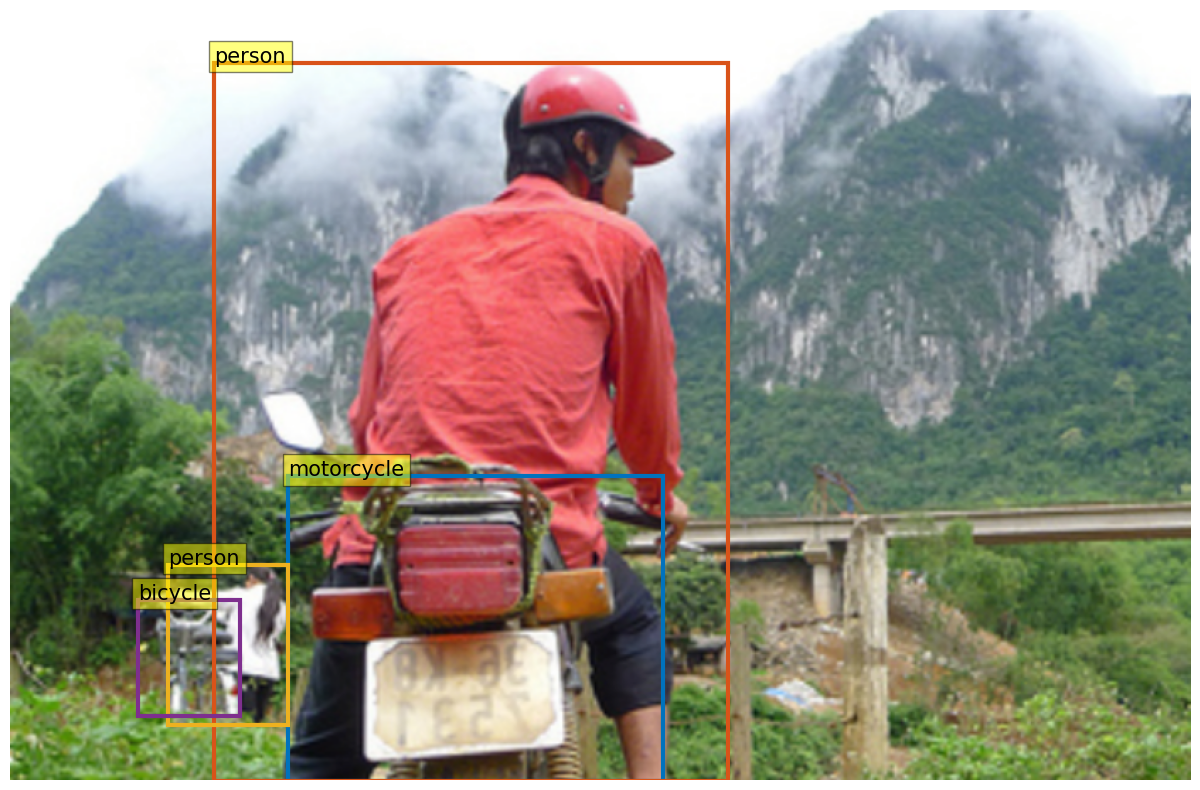

In [22]:
sample = datasets[0][0]
plot_results(sample["img"].data, sample["gt_labels"].data, sample["gt_bboxes"].data)

1333

In [16]:
img = sample["img"].data
h, w = img.shape[1:]
rescale_bboxes(sample["gt_bboxes"].data, (w, h))

tensor([[ 256.9358,  -70.2083, 1239.2318,  679.2500],
        [ 193.7015, -290.1771, 1222.1111,  382.5104],
        [ 453.7616,  129.9167, 1510.9139,  590.1666],
        [ 474.2356,  154.5104, 1550.2999,  609.2812]])

In [ ]:
sample["gt_bboxes"].data